# Case Study: Mechanistic Models

Plots for Fig. 6f and additional plots for Appendix D

### Auxiliary code + plotting setup

In [ ]:
import sys
sys.path = ['../'] + sys.path

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
from matplotlib import gridspec
import pandas as pd

In [4]:
# Set tex formatting for plots
# Set tex formatting for plots
matplotlib.rc('text', usetex = True)
matplotlib.rc('font', **{'family' : "sans-serif"})
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

#plt.rcParams["font.family"] = "serif"
#plt.rcParams["font.serif"] = ["Computer Modern Roman"]

# Set legend size
#from matplotlib.font_manager import FontProperties
#fontP = FontProperties()
#fontP.set_size('small')

In [5]:
matplotlib.rcParams.update({'font.size': 7})
MM = 1/25.4

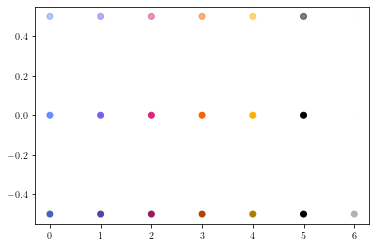

In [6]:
def to_rgb(H, b=1, a=1):
    RGBa = []
    for h in H:
        h = h.lstrip("#")
        RGBa.append(tuple(int(h[i:i+2], 16) / 256 * b for i in (0, 2, 4)) + (a,))
    return np.array(RGBa)

# Color palettes
color_blind_1 = ['#d73027', '#fc8d59', '#fee090', '#91bfdb', '#4575b4', '#020202',]
color_blind_2 = ['#b2182b', '#d6604d', '#f4a582', '#fddbc7', '#d1e5f0', '#92c5de', '#4393c3', '#2166ac']
color_blind_3 = ['#8c510a', '#bf812d', '#dfc27d', '#f6e8c3', '#c7eae5', '#80cdc1', '#35978f', '#01665e']
ibm_color_blind = ["#648fff", "#785ef0", "#dc267f", "#fe6100", "#ffb000", "#000000", "#ffffff"]
rainbow10 = ["#ff4365", "#ffdd43", "#59ff43", "#43ffdd", "#7395ff", "#4365ff", "#e943ff", "#601e9e", "#6a6a6a", "#964b00"]


# Pick one and show

palette = ibm_color_blind

base = to_rgb(palette)
basea = to_rgb(palette, a=0.5)
baseb = to_rgb(palette, b=0.7)
plt.scatter(np.arange(len(base)), np.zeros(len(base)), c = base)
plt.scatter(np.arange(len(base)), np.ones(len(base))*0.5, c = basea)
plt.scatter(np.arange(len(base)), np.ones(len(base))*-0.5, c = baseb)

from matplotlib import ticker
def format_y_axis(ax, label="", right=False, rotation=90, ha="center", va="bottom"):
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True) 
    formatter.set_powerlimits((-1,1)) 
    ax.yaxis.set_major_formatter(formatter)
    if right:
        ax.yaxis.set_label_position("right")
        ax.yaxis.tick_right()

    ax.figure.canvas.draw() # Must draw to get offset below
    ax.yaxis.offsetText.set_visible(False)
    offset = ax.yaxis.get_major_formatter().get_offset()    
    ax.yaxis.set_label_text(label + " " + offset, rotation=rotation, ha=ha, va=va)

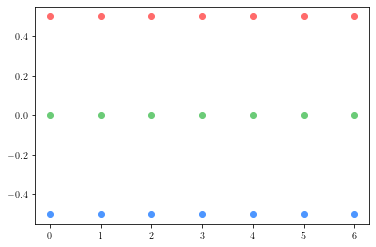

In [7]:
# RGB palette for some of the plots

red = "#FF6B6B"
green = "#6BCB77"
blue = "#4D96FF"
plt.scatter(np.arange(len(base)), np.ones(len(base))*0.5, color=red)
plt.scatter(np.arange(len(base)), np.zeros(len(base)), color=green)
plt.scatter(np.arange(len(base)), np.ones(len(base))*-0.5, color=blue)

## Plots for appendix D1

Models B1, A1 and A2

In [8]:
from causalchamber.models import model_b1, model_a1, model_a2


Fetching list of available datasets from https://causalchamber.s3.eu-central-1.amazonaws.com/downloadables/directory.yaml ... done.
If you use our datasets or models for your work please consider citing:

@article{gamella2024chamber,
  title={The Causal Chambers: Real Physical Systems as a Testbed for AI Methodology},
  author={Gamella, Juan L. and B"uhlmann, Peter and Peters, Jonas},
  journal={arXiv preprint arXiv:TODO},
  year={2024}
}



### Calibrate current sensors (i.e. get correct reference voltages)

Use the `current_calibration` experiment from the `wt_test_v1 dataset`.

In [9]:
# Load dataset
import causalchamber.datasets as datasets
dataset = datasets.Dataset("wt_test_v1", root="/tmp")
df = dataset.get_experiment("analog_calibration").as_pandas_dataframe()

# Calibration for current_in sensor
medians = df.groupby('v_in').current_in.median() / 1023 * 2.5
ref_voltages_in = medians[5.0] / medians * 5

# Calibration for current_in sensor
medians = df.groupby('v_out').current_out.median() / 1023 * 2.5
ref_voltages_out = medians[5.0] / medians * 5

print("Estimated reference voltages")
ref_voltages_in, ref_voltages_out

Dataset wt_test_v1 found in "/tmp/wt_test_v1".
Estimated reference voltages


(v_in
 1.10    1.160068
 2.56    2.650778
 5.00    5.000000
 Name: current_in, dtype: float64,
 v_out
 1.10    1.158403
 2.56    2.650602
 5.00    5.000000
 Name: current_out, dtype: float64)

In [10]:
vref = 1.16

### Estimate the no-load current

Using the `no_load` experiment from the `wt_test_v1 dataset`.

In [11]:
df = dataset.get_experiment("no_load").as_pandas_dataframe()

In [12]:
# Intake fan
current_load_0 = df[df.flag == 0].current_in.mean() / 1023 * 2.5 * vref / 5
current_load_001 = df[df.flag == 1].current_in.mean() / 1023 * 2.5 * vref / 5
print(current_load_0, current_load_001)

0.1661043743890518 0.1672078201368524


In [13]:
# Exhaust fan
current_load_0 = df[df.flag == 2].current_in.mean() / 1023 * 2.5 * vref / 5
current_load_001 = df[df.flag == 3].current_in.mean() / 1023 * 2.5 * vref / 5
print(current_load_0, current_load_001)

0.1663269061583577 0.16626950146627564


We estimate the no-load current as `0.166`

### Set model parameters

In [14]:
# For models A1 and B1
C_MIN = 0.166 # estimated above
C_MAX = 0.27
L_MIN = 0.1
OMEGA_MAX = 3000 * np.pi / 30

# For model A2
I = 0.5 * 0.059**2 * 0.02 # modelled as a solid disk: I = 1/2 * r^2 * m
T = 0.05
# Torque function \tau(L) defined in model A2, Appendix IV
def tau(L, C_min=C_MIN, C_max=C_MAX, L_min=L_MIN, T=T):
    L = np.atleast_1d(L)
    torques = T * (C_min + np.maximum(L_min, L) ** 3 * (C_max - C_min) - C_min)
    torques[L == 0] = 0
    return torques if len(L) > 1 else torques[0]

# def tau(L, C_min=C_MIN, C_max=C_MAX, L_min=L_MIN, T=T):    
#    return T * (C_min + np.maximum(L_min, L) ** 3 * (C_max - C_min) - C_min)    

C = tau(1) / OMEGA_MAX**2
print("I", I)
print("C", C)

# For models C2 and C3 (see below)
Q_MAX = 186.7 / 3600  # m3 / s
print("Q_MAX",Q_MAX)
S_MAX = 74.82473949999999 # pascals
BETA = 0.15
r = 0.75
r_0 = 0.75

I 3.481e-05
C 5.268701549401565e-08
Q_MAX 0.05186111111111111


### Download datasets for plots

- For steady-state plots: `random_loads_intake` experiment from `wt_bernoulli_v1` dataset
- For steady-state plots: `steps` experiment form the `wt_test` dataset (same as for Fig. 6f)

In [15]:
import causalchamber.datasets as datasets
dataset = datasets.Dataset("wt_bernoulli_v1", root="/tmp")
df = dataset.get_experiment("random_loads_intake").as_pandas_dataframe().sample(1000,random_state=42)

dataset = datasets.Dataset("wt_test_v1", root='/tmp')
df_steps = dataset.get_experiment("steps").as_pandas_dataframe()

Dataset wt_bernoulli_v1 found in "/tmp/wt_bernoulli_v1".
Dataset wt_test_v1 found in "/tmp/wt_test_v1".


In [16]:
load_in = df.load_in
rpm_in = df.rpm_in
current_in = df.current_in / 1023 * 2.5 / 5 * 1.16 # Calibrate current reading (using corrected reference voltage (1.16V) for 1.1V from above)

### Run models and plot results

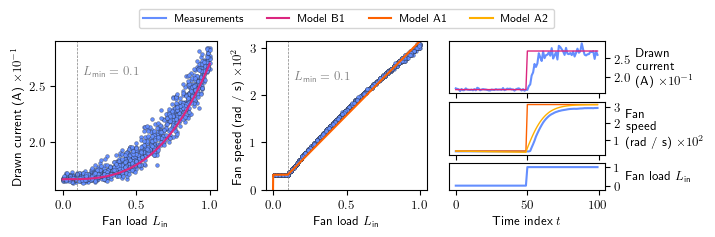

In [17]:
fig = plt.figure(figsize=(180*MM,50*MM), dpi=100)
matplotlib.rcParams.update({'font.size': 9})

# Set up subplots
gs_left = gridspec.GridSpec(1, 2)
gs_right = gridspec.GridSpec(3, 1, height_ratios=[0.4,0.4,0.2])

ax1 = fig.add_subplot(gs_left[0])
ax2 = fig.add_subplot(gs_left[1])
ax31 = fig.add_subplot(gs_right[0])
ax32 = fig.add_subplot(gs_right[1])
ax33 = fig.add_subplot(gs_right[2])

gs_left.update(right=0.65)
gs_right.update(left=0.68)
gs_left.update(wspace=0.3)

# Parameters for plotting measurements and model outputs
kwargs = {'linewidth': 1, 's': 30, 'color':base[0], 'edgecolor':"#222222", 'linewidth':0.2}
l = np.linspace(0,1,1000)

# --------------------------------
# Model B1 vs steady-state current
ax1.scatter(load_in, current_in, marker='.', **kwargs, label="Measurements")
ax1.plot(l, model_b1(l, C_MIN, C_MAX, L_MIN), color=base[2], label="Model B1")
ax1.axvline(0.1, linewidth=0.5, color="gray", linestyle='--')
format_y_axis(ax1, "Drawn current (A)")
ax1.set_xlabel("Fan load $L_\\text{in}$")

# --------------------------------
# Model A1 vs steady-state speed
mask = load_in != 0
ax2.scatter(load_in[mask], rpm_in[mask] * np.pi / 30, marker='.', **kwargs, label="Measurements")
ax2.set_ylim([0,OMEGA_MAX])
#ax.axhline(rpm_in.min(), color="gray", linestyle="--")
ax2.axvline(0.1, linewidth=0.5, color="gray", linestyle='--')
ax2.plot(l, model_a1(l, L_MIN, OMEGA_MAX), color=base[3], label="Model A1")
format_y_axis(ax2, "Fan speed (rad / s)")
ax2.set_xlabel("Fan load $L_\\text{in}$")
#ax2.legend(prop={'size': 7})

# ------------------------------------------------------------------
# Models A1, A2, B1 vs speed and current dyanmics (steps experiment)
t = 100
load = df_steps.load_in[0:t]
current = df_steps.current_in[0:t] / 1023 * 2.5 * 1.16 / 5
rpm = df_steps.rpm_in[0:t] * np.pi / 30

ax31.plot(df_steps.index[0:t], current, color=base[0])
ax31.plot(df_steps.index[0:t], model_b1(load, C_MIN, C_MAX, L_MIN), color=base[2], linewidth=1, label="Model B1")
format_y_axis(ax31, "Drawn\ncurrent\n(A)", True, rotation=0, ha="left", va="center")
ax31.set_xticklabels([])
#ax31.legend(prop={'size': 7})

ax32.plot(df_steps.index[0:t], rpm, color=base[0], label="Measurements")
#plt.ylim([0,3100])
ax32.plot(df_steps.index[0:t], model_a1(load, L_MIN, OMEGA_MAX), color=base[3], linewidth=1, label="Model A1")
ax32.plot(df_steps.index[0:t], model_a2(load, I, tau, C, omega_0 = L_MIN * OMEGA_MAX, timestamps = df_steps[0:t].timestamp), color=base[4], linewidth=1, label="Model A2")
format_y_axis(ax32, "Fan\nspeed\n(rad / s)", True, rotation=0, ha="left", va="center")
ax32.set_xticklabels([])
#ax32.legend(prop={'size': 6})

ax33.plot(df_steps.index[0:t], df_steps.load_in[0:t], color=base[0], label="Measurements")
plt.ylim([-.2,1.2])
format_y_axis(ax33, "Fan load $L_\\text{in}$", True, rotation=0, ha="left", va="center")
#ax32.legend(prop={'size': 6})
ax33.set_xlabel("Time index $t$")


# Make legend and other labels
legend_elements = [Line2D([0], [0], color=base[0], label='Measurements'),
                   Line2D([0], [0], color=base[2], label='Model B1'),
                   Line2D([0], [0], color=base[3], label='Model A1'),
                   Line2D([0], [0], color=base[4], label='Model A2'),
                  ]
ax2.legend(handles=legend_elements, ncol=5, prop={'size': 8}, loc='center', bbox_to_anchor=(0.5,1.15))
ax1.text(0.14, 0.26, r"$L_\text{min} = 0.1$", color="gray")
ax2.text(0.14, 232, r"$L_\text{min} = 0.1$", color="gray")

# Save the figure
plt.savefig("../figures/wt_models.pdf", bbox_inches="tight")

**Check effect of zero load on model A2**

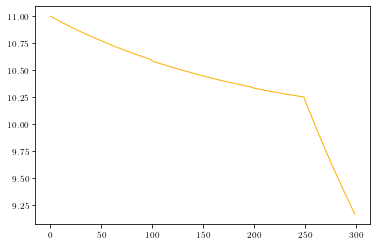

In [18]:
load = np.array([L_MIN] * 250 + [0] * 50)
plt.plot(model_a2(load, I, tau, C, omega_0 = 11, timestamps = df_steps.timestamp), color=base[4], linewidth=1, label="Model A2")

## Plots for Appendix D2

Model E1

In [19]:
import causalchamber.datasets as datasets
dataset = datasets.Dataset("lt_malus_v1", root="/tmp")
dfs = [
    dataset.get_experiment("white_64").as_pandas_dataframe().sample(1000,random_state=42),
    dataset.get_experiment("white_128").as_pandas_dataframe().sample(1000,random_state=42),
    dataset.get_experiment("white_255").as_pandas_dataframe().sample(1000,random_state=42)
]
setting = [64, 128, 255]

Dataset lt_malus_v1 found in "/tmp/lt_malus_v1".


In [20]:
import matplotlib.text as mtext

class LegendTitle(object):
    def __init__(self, text_props=None):
        self.text_props = text_props or {}
        super(LegendTitle, self).__init__()

    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        title = mtext.Text(x0, y0, orig_handle, usetex=True, **self.text_props)
        handlebox.add_artist(title)
        return title


0.9336653960650863
0.9700450339276355
0.9944125985775162


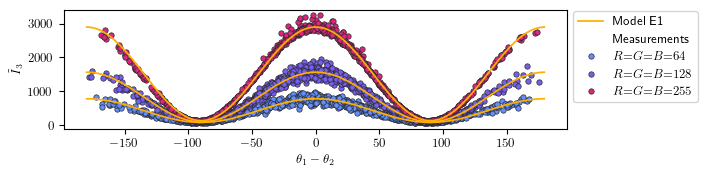

In [21]:
fig = plt.figure(figsize=(165*MM,40*MM), dpi=100)
kwargs = {'marker': 'o', 's':15, 'edgecolor': '#2a2a2a', 'linewidth': 0.5}
from sklearn.linear_model import LinearRegression

l = np.arange(-180,180,0.5)
handles_points = []
handles_lines = []
for i,(dfw,rgb) in enumerate(zip(dfs, setting)):
    
    # Model E1 fit to data
    X = np.atleast_2d(np.cos(np.deg2rad(dfw.pol_1 - dfw.pol_2))**2)
    reg = LinearRegression().fit(X.T, dfw.ir_3.values)
    print(reg.score(X.T, dfw.ir_3.values))
    plt.plot(l, reg.intercept_ + reg.coef_ * np.cos(np.deg2rad(l))**2, color=base[4], label="Model E1" if i == 0 else None, linewidth=1.25)    
    
    # Plot measurements
    plt.scatter(dfw.pol_1 - dfw.pol_2, dfw.ir_3, **kwargs, color=base[i], label="$R$=$G$=$B$=$%d$" % rgb)
    
    
plt.xlabel(r"$\theta_1  - \theta_2$")
plt.ylabel(r"$\tilde{I}_3$")

handles, labels = plt.gca().get_legend_handles_labels()

handles.insert(1, Line2D([0], [0], linewidth=0))
labels.insert(1, 'Measurements')

plt.legend(handles = handles, labels=labels, ncol=1, prop={'size': 9}, loc='upper left', bbox_to_anchor=(1,1.04))
plt.savefig("../figures/polarizer_model.pdf", bbox_inches="tight")

## Wind Tunnel Models (Fig. 6f)

Load dataset

In [22]:
import causalchamber.datasets as datasets
dataset = datasets.Dataset("wt_test_v1", download=True, root="/tmp")
df = dataset.get_experiment("steps").as_pandas_dataframe()

Dataset wt_test_v1 found in "/tmp/wt_test_v1".


### Run simulators

In [23]:
from causalchamber.models import model_a1, model_a2, simulator_a1_c2, simulator_a1_c3, simulator_a2_c3

In [24]:
inputs = df.copy().iloc[0:200]
inputs.rpm_in *= np.pi / 30
inputs.rpm_out *= np.pi / 30
loads_in = inputs.load_in
loads_out = inputs.load_out
hatch = inputs.hatch
timestamps = inputs.timestamp - inputs.timestamp[0]
P_amb = inputs.pressure_downwind[0]
BAROMETER_ERROR = 0
BAROMETER_PRECISION = 0.2

est_a1c2 = simulator_a1_c2(    
    loads_in,
    loads_out,
    hatch,
    P_amb,    
    L_MIN,
    OMEGA_MAX,    
    S_MAX,
    Q_MAX,
    r,    
    BAROMETER_ERROR,
    BAROMETER_PRECISION,
random_state=3)

est_a1c3 = simulator_a1_c3(
    loads_in,
    loads_out,
    hatch,
    P_amb,    
    L_MIN,
    OMEGA_MAX,
    S_MAX,
    Q_MAX,
    r_0,
    BETA,    
    BAROMETER_ERROR,
    BAROMETER_PRECISION,
random_state=2)

est_a2c3 = simulator_a2_c3(
    # Input
    loads_in,
    loads_out,
    hatch,
    P_amb,
    # Parameters for model A1
    I,
    tau,
    C,
    timestamps,
    model_a1(loads_in.iloc[0], L_MIN, OMEGA_MAX), # intial fan speeds
    model_a1(loads_out.iloc[0], L_MIN, OMEGA_MAX), # initial fan speeds
    # Parameters for model C3
    S_MAX,
    OMEGA_MAX,
    Q_MAX,
    r_0,
    BETA,
    # Sensor noise
    BAROMETER_ERROR,
    BAROMETER_PRECISION,
random_state=3)

### Plot results

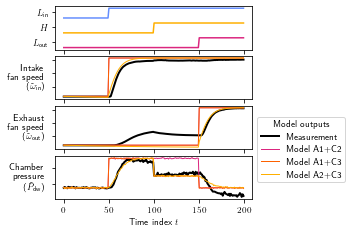

In [25]:
plt.figure(figsize=(90*MM,90*MM))
gs = gridspec.GridSpec(4, 1, wspace=0, hspace=0.15)#, height_ratios = [.22, .26, .26, .26])
kwargs = {'linewidth': 1}

plt.subplot(gs[0])
ax = plt.gca()
plt.plot(inputs.load_in, label="Intake power $L_{in}$", color=base[0])
plt.plot(inputs.hatch / 45 - 1.5, label="Hatch position ($H$)", color=base[4])
plt.plot(inputs.load_out - 3, label="Exhaust power $L_{out}$", color=base[2])
plt.yticks(np.array([0,-1.5,-3])+0.6, [r'$L_\text{in}$', r'$H$', r'$L_\text{out}$'])
#plt.ylabel("Actuators", rotation=0, ha="right", va='center')
plt.gca().set_xticklabels([])
# plt.legend(bbox_to_anchor=(1.01,1.15), loc='upper left', title="Actuator inputs")

plt.subplot(gs[1])
plt.plot(inputs.rpm_in, label="Measurement", color=base[5], linewidth=2, linestyle='-')
#plt.plot(est_i.rpm_in, label="Model I", **kwargs, color=base[1])
plt.plot(est_a1c2[1], label="Model A1+C2", **kwargs, color=base[2])
plt.plot(est_a1c3[1], label="Model A1+C3", **kwargs, color=base[3])
plt.plot(est_a2c3[1], label="Model A2+C3", **kwargs, color=base[4])
plt.ylabel("Intake\nfan speed\n($\\tilde{\omega}_\\text{in}$)", rotation=0, ha="right", va='center')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
#plt.ylim([0,3100])

plt.subplot(gs[2])
plt.plot(inputs.rpm_out, label="Measurement", color=base[5], linewidth=2)
#plt.plot(est_i.rpm_out, label="Model I", **kwargs, color=base[1])
plt.plot(est_a1c2[2], label="Model A1+C2", **kwargs, color=base[2])
plt.plot(est_a1c3[2], label="Model A1+C3", **kwargs, color=base[3])
plt.plot(est_a2c3[2], label="Model A2+C3", **kwargs, color=base[4])
plt.ylabel("Exhaust\nfan speed\n($\\tilde{\omega}_\\text{out}$)", rotation=0, ha="right", va='center')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])

plt.subplot(gs[3])
plt.plot(inputs.pressure_downwind, label="Measurement", color=base[5], linewidth=2)
#plt.plot(est_i.pressure_downwind, label="Model I", **kwargs, color=base[1])
plt.plot(est_a1c2[0], label="Model A1+C2", **kwargs, color=base[2])
plt.plot(est_a1c3[0], label="Model A1+C3", **kwargs, color=base[3])
plt.plot(est_a2c3[0], label="Model A2+C3", **kwargs, color=base[4])
plt.ylabel("Chamber\npressure\n($\\tilde{P}_\\text{dw}$)", rotation=0, ha="right", va='center')
#plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.xlabel("Time index $t$")
plt.legend(bbox_to_anchor=(1,2), loc='upper left', title="Model outputs", ncol=1)

plt.savefig("../figures/wt_simulators.pdf", bbox_inches="tight")

## Image Capture Models

Described in Appendix D2

### Define model parameters

#### Sensor response matrix $S$

We use the SONY NEX-5N data from https://www.gujinwei.org/research/camspec/db.html

array([[0.2995802 , 0.06920322, 0.028159  ],
       [0.04017132, 0.9209918 , 0.31265   ],
       [0.00217392, 0.2071558 , 0.75763   ]])

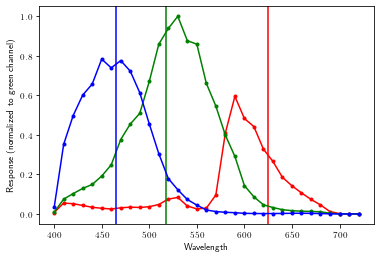

In [26]:
# Load camera spectral sensitivity
sens = pd.read_csv("camera_sensitivity.csv", index_col='channel')

# Light-source wavelengths
color_wavelengths = pd.read_csv("light_source_wavelengths.csv", index_col=0)
wavelengths = color_wavelengths.typical

# Plot
channels = ['red', 'green', 'blue']
for response,channel,wavelength in zip([sens.loc[c] for c in channels], channels, wavelengths):        
    t = response.index.values.astype(int)
    plt.plot(t,response.values, color=channel, marker='.')
    plt.gca().axvline(wavelength, color=channel)
    plt.xlabel("Wavelength")
    plt.ylabel("Response (normalized to green channel)")
    
# Build S matrix
S = np.zeros((3,3))
for i,channel_response in enumerate([sens.loc[c] for c in channels]):    
    for j,wavelength in enumerate(wavelengths):
        S[i,j] = np.interp(wavelength, sens.columns.astype(int), channel_response)
S

#### White balance $w_R, w_G, w_B$

We use the values from the Sony Alpha 6500 (see https://www.rawdigger.com/node/429)

In [27]:
#wb = np.array([2.183594, 1.000000, 1.519531])
wb = np.array([2.65625, 1.0, 1.77344])
W = np.diag(wb)

### Load data

Using the `palette` and `polarizer_effect_bright` experiments from the `lt_camera_test_v1` dataset.

In [28]:
dataset = datasets.Dataset("lt_camera_test_v1", root="/tmp")
dataset.available_experiments()
images_palette = dataset.get_experiment("palette").as_image_array('500')[0:15]
df_palette = dataset.get_experiment("palette").as_pandas_dataframe().iloc[0:15]
images_polarizers = dataset.get_experiment("polarizer_effect_bright").as_image_array('500')
df_polarizers = dataset.get_experiment("polarizer_effect_bright").as_pandas_dataframe()

images = np.concatenate([images_palette, images_polarizers], axis=0)
df = pd.concat([df_palette, df_polarizers], ignore_index=True)

Dataset lt_camera_test_v1 found in "/tmp/lt_camera_test_v1".


### Run models and compare to ouput

In [29]:
from causalchamber.models import model_f1, model_f2, model_f3

234.0 175.0 65.0 0.0 0.0
72.0 165.0 106.0 0.0 0.0
128.0 0.0 128.0 90.0 0.0


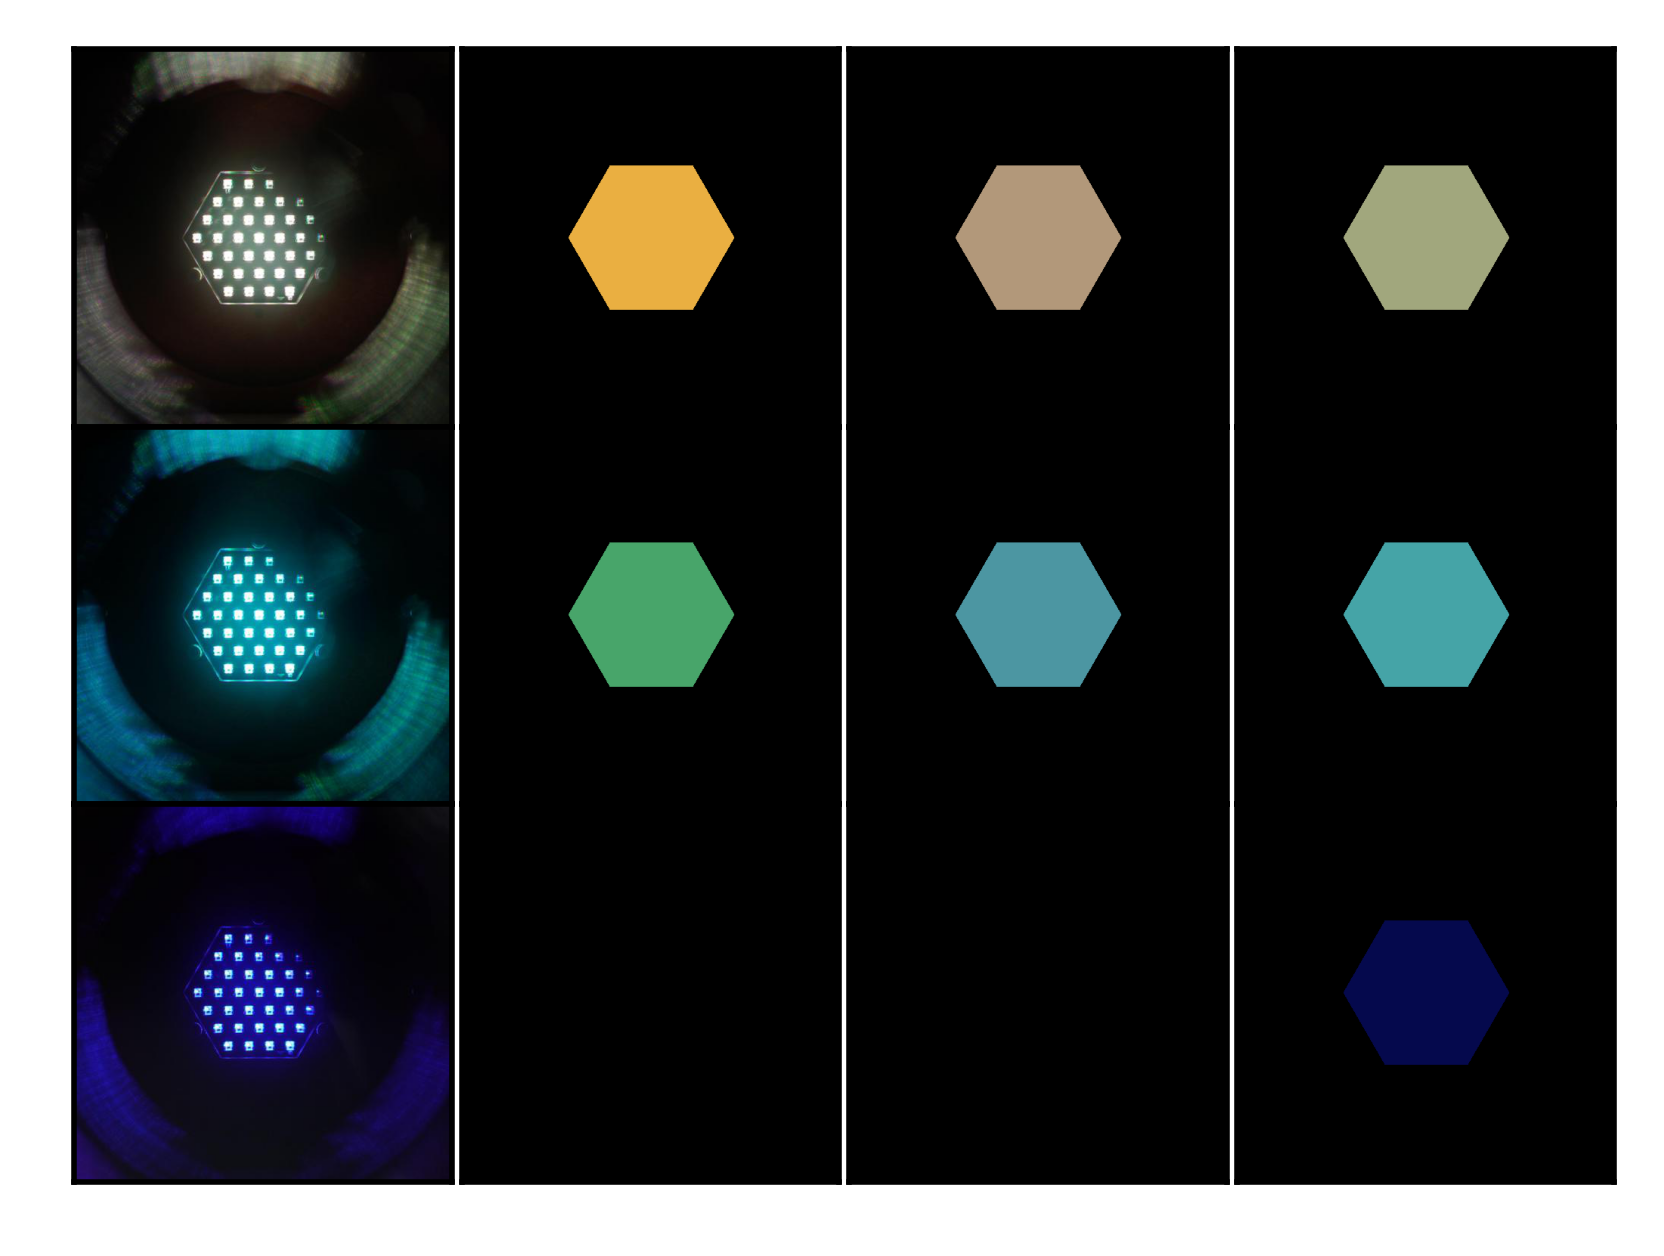

In [30]:
plt.figure(figsize=(4,len(images)*1), dpi=500)
gs = gridspec.GridSpec(len(images), 4, wspace=0, hspace=0)#, height_ratios = [.22, .26, .26, .26])

kwargs = {"center_x": 0.5, "center_y": 0.5, "radius": 0.22, "offset": 0, "image_size":500}
for i,j in enumerate([12,11,-1]):
    image = images[j]
    obs = df.iloc[j]    
    
    plt.subplot(gs[i,0])
    ax = plt.gca()
    plt.imshow(image)
    plt.yticks([])
    plt.xticks([])
    
    plt.subplot(gs[i,1])
    ax = plt.gca()
    s1 = model_f1(obs.red, obs.green, obs.blue, obs.pol_1, obs.pol_2, **kwargs)
    print(obs.red, obs.green, obs.blue, obs.pol_1, obs.pol_2)
    ax.imshow(s1)
    plt.yticks([])
    plt.xticks([])
    
    plt.subplot(gs[i,2])
    ax = plt.gca()
    s1 = model_f2(obs.red, obs.green, obs.blue, obs.pol_1, obs.pol_2, **kwargs, S=S, w_r=wb[0], w_g=wb[1], w_b=wb[2], exposure=0.8)#0.6)
    ax.imshow(s1)
    plt.yticks([])
    plt.xticks([])
    
    plt.subplot(gs[i,3])
    ax = plt.gca()
    Tp = np.array([[0.29, 0.35, 0.33]]).T
    Tc = np.array([[0.02, 0.08, 0.18]]).T    
    s1 = model_f3(obs.red, obs.green, obs.blue, obs.pol_1, obs.pol_2, **kwargs, S=S, w_r=wb[0], w_g=wb[1], w_b=wb[2], exposure=2.5, Tp=Tp, Tc=Tc) # 1.8
    ax.imshow(s1)
    plt.yticks([])
    plt.xticks([])
    plt.savefig(f"../figures/image_capture_simulators.pdf", transparent=True, bbox_inches="tight")